# Modèle de prévision d'achalandage 

Étapes
1. Analyse préliminaire
2. Analyse descriptive
   - Croisement de différentes sources (?): enquête web, profil clientèle (étudiants, travailleurs...)
3. Analyse prédictive (prochain 18-24 mois)
   - Définition du plan de match (modèles à tester, variables à utiliser, mesure de performance...)
   - Préparation des données (nettoyage abberants, décomposition STL...)
   - Élaboration du modèle
      - Sans facteur exogène
      - Avec facteur exogène
   - Test du modèle
   - Modification et amélioration de la performance du modèle
   - Opérationnalisation du modèle

In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import radm_utils.db_connection as dbc
import numpy as np
import pickle

from sklearn.linear_model import LinearRegression
import seaborn as sns
import datetime as dt
from datetime import datetime, time
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import plotly.express as px

In [7]:
DIR = 'I:/8.05.00 - MODELISATION/8.05.122 - Prévisions achalandage/80 - Documents de travail/2023/TC/0_Données utilisées/'
FILE = 'Donnees_tc.csv'
DIR_MOD = 'C:/Users/mmizrahi/codes/previsions_achalandage/Model_pkl/'
#os.path.join(os.path.expanduser('~'),'codes/import_offre_service/')

#secteur = ['CITLA','exo2']
#date_ech = '2022--01'

In [3]:
##Modèles ajustées - historiques
DICT_MOD = {
    'exo1': {
        'model_order': [0,1,1],
        'seasonal_order': [2,1,1,12],
        'date_ech': '2022-09-01'
     },
    'exo2': {
        'model_order': [0,1,1],
        'seasonal_order': [2,1,1,12],
        'date_ech': '2022-09-01'
     },
    'exo3': {
        'model_order': [0,1,1],
        'seasonal_order': [1,1,1,12],
        'date_ech': '2022-06-01'
     },
    'exo4': {
        'model_order': [1,1,0],
        'seasonal_order': [0,1,1,12],
        'date_ech': '2022-09-01'
     },
    'exo5': {
        'model_order': [0,1,3],
        'seasonal_order': [1,1,1,12],
        'date_ech': '2022-09-01'
     },
    'CIHSL': {
        'model_order': [2,1,1],
        'seasonal_order': [2,1,1,12],
        'date_ech': '2022-12-01'
     },
    'CITLA': {
        'model_order': [0,1,0],
        'seasonal_order': [2,1,1,12],
        'date_ech': '2022-12-01'
     },
    'CITPI': {
        'model_order': [0,1,3],
        'seasonal_order': [0,1,1,12],
        'date_ech': '2023-01-01'
     },
    'CITSO': {
        'model_order': [0,1,0],
        'seasonal_order': [0,1,1,12],
        'date_ech': '2022-12-01'
     },
    'CITSV': {
        'model_order': [0,1,1],
        'seasonal_order': [0,1,2,12],
        'date_ech': '2022-12-01'
     },
    'CITVR': {
        'model_order': [2,1,0],
        'seasonal_order': [2,1,2,12],
        'date_ech': '2023-01-01'
     },
    'MRCLASSO': {
        'model_order': [0,1,1],
        'seasonal_order': [0,1,2,12],
        'date_ech': '2022-12-01'
     },
    'MRCLM': {
        'model_order': [1,1,0],
        'seasonal_order': [0,1,2,12],
        'date_ech': '2023-01-01'
     },
    'OMTISJU': {
        'model_order': [0,1,1],
        'seasonal_order': [1,1,1,12],
        'date_ech': '2023-01-01'
     }
    }

### Préparation des données

In [4]:
data = pd.read_csv(os.path.join(DIR, FILE), sep = ';')
#secteur = data['secteur'].unique()
secteur = ['CITLA']

In [5]:
data['month'] = pd.Categorical(pd.to_datetime(data['date']).dt.month)
data['year'] = pd.Categorical(pd.to_datetime(data['date']).dt.year)
data = data[(~data['secteur'].isin([secteur])) &
            (pd.to_datetime(data['date']).dt.year >= 2017)] \
            .reset_index(drop=True) #Ligne deux-montanges n'existe plus

### Graphiques

In [6]:
for sect in secteur:
    fig = px.line(data[data['secteur']==sect], x="date", y="montants",
                    title='Montants - ' + sect)
    fig.update_traces(mode="markers+lines")
    fig.show()

### Prévisions

In [20]:
secteur=['CITLA','exo2']

Ajustement du modèle

In [29]:
def ajustement_mod(data,
                   secteur: list,
                   dir_mod = DIR_MOD,
                   dict: str = DICT_MOD,                   
                   maj: bool = True):
    
    data_trainL = []
    data_testL = []
    # model = []
    # summary = []
    final_model = []
    result = []
    predictions = []

    dict_filter = {k:v for k,v in dict.items() if k in secteur}
    dict_filter

    for sect in secteur:
        if maj == True:

            onlyfiles = [f for f in listdir(dir_mod) if isfile(join(dir_mod, f))]

            print(sect)
            sub_data = data[data.secteur==sect].reset_index(drop=True)
            data_trainL.append(sub_data[sub_data['date'] < dict_filter[sect]['date_ech']])
            data_testL.append(sub_data[sub_data['date'] >= dict_filter[sect]['date_ech']])

            final_model.append(SARIMAX(data_trainL[secteur==sect].montants,
                                        order=(dict_filter[sect]['model_order']),
                                        seasonal_order=(dict_filter[sect]['seasonal_order'])))
            
            #result.append(final_model[secteur==sect].fit())
                            #,open('Model_SARIMA_' + str(sect) + datetime.now().strftime("%Y-%m-%d") +'.pkl', 'wb')))               
            #save = True                         
            final_model[secteur==sect].fit().save('Model_SARIMA_' + str(sect) + '_' + datetime.now().strftime("%Y-%m-%d") +'.pkl')
            with open('Model_SARIMA_' + str(sect) + datetime.now().strftime("%Y-%m-%d" + '.pkl'), 'rb') as picklefile:
                result.append(pickle.load(picklefile))
        
        #Graphique résidus
        #result[secteur==sect].plot_diagnostics(figsize=(15, 12))

        #Obtenir les valeurs prédites
        start=len(data_trainL[secteur==sect])
        end=len(data_trainL[secteur==sect])+len(data_testL[secteur==sect])-1

        predictions.append(result[secteur==sect] 
                        .predict(start=start, end=end, dynamic=False, typ='levels') 
                        .rename(str(sect) 
                                + ' - SARIMA (' 
                                + str(dict_filter[sect]['model_order']) 
                                + ') ('
                                + str(dict_filter[sect]['seasonal_order']) 
                                + ') - Predictions'))

CITLA


c:\Users\mmizrahi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\mmizrahi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

c:\Users\mmizrahi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



exo2


c:\Users\mmizrahi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [ ]:
#Ajustement automatisé des modèles ARIMA
# model.append(pm.auto_arima(data_trainL[secteur==sect].montants,
#                 start_p=0, start_q=0,
#                 test='adf',       # use adftest to find optimal 'd'
#                 max_p=5, max_q=5, # maximum p and q
#                 m=12,              # frequency of series
#                 start_P=0, start_Q=0,
#                 max_P=5, max_Q=5,
#                 d=None,           # let model determine 'd'
#                 seasonal=True,     # Seasonality
#                 #d=1,
#                 D=1,
#                 trace=True,
#                 maxiter=70,
#                 information_criterion='aic',
#                 error_action='ignore',
#                 suppress_warnings=True,
#                 stepwise=True))  
                                
#summary.append(model[].summary())

In [9]:
#list(map(dict_mod.get, filter(dict_mod.__contains__, secteur)))

[{'model_order': [0, 1, 0], 'seasonal_order': [2, 1, 1, 12]},
 {'model_order': [0, 1, 1], 'seasonal_order': [2, 1, 1, 12]}]

CITLA


C:\Users\mmizrahi\AppData\Local\Temp\ipykernel_17476\1629060355.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mmizrahi\AppData\Local\Temp\ipykernel_17476\1629060355.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



exo2


C:\Users\mmizrahi\AppData\Local\Temp\ipykernel_17476\1629060355.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mmizrahi\AppData\Local\Temp\ipykernel_17476\1629060355.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



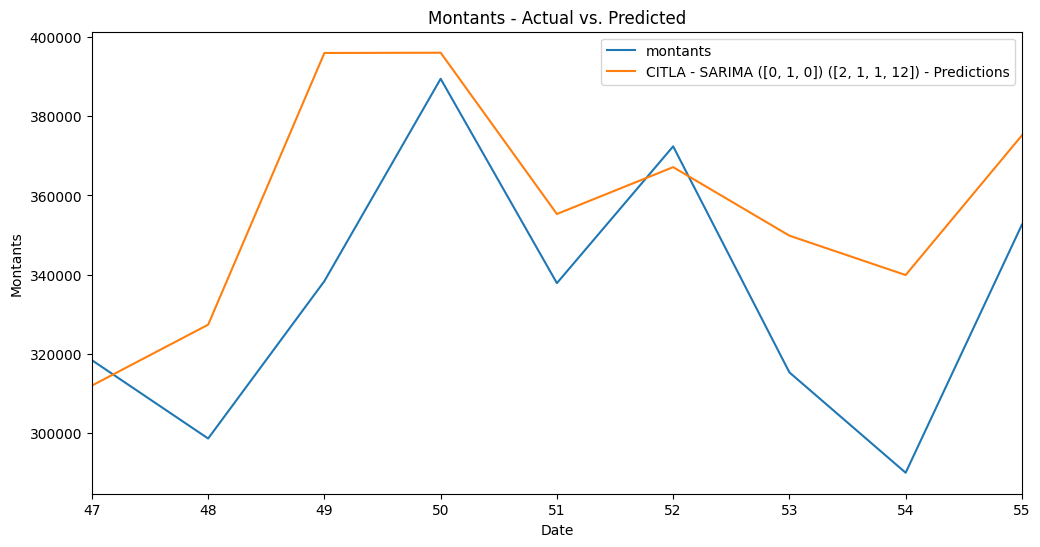

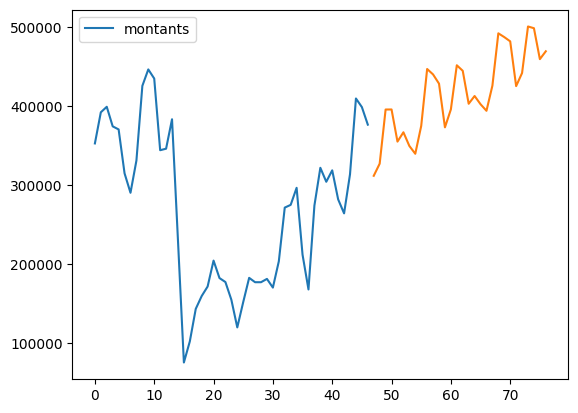

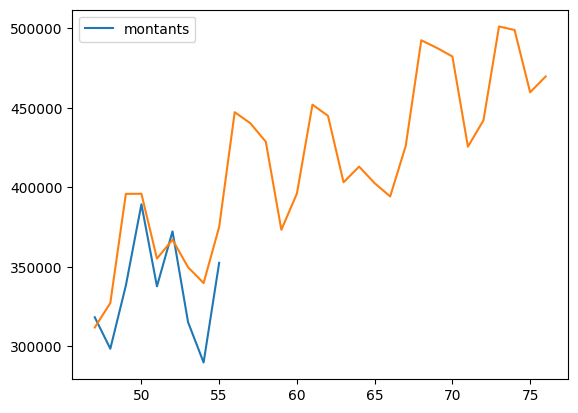

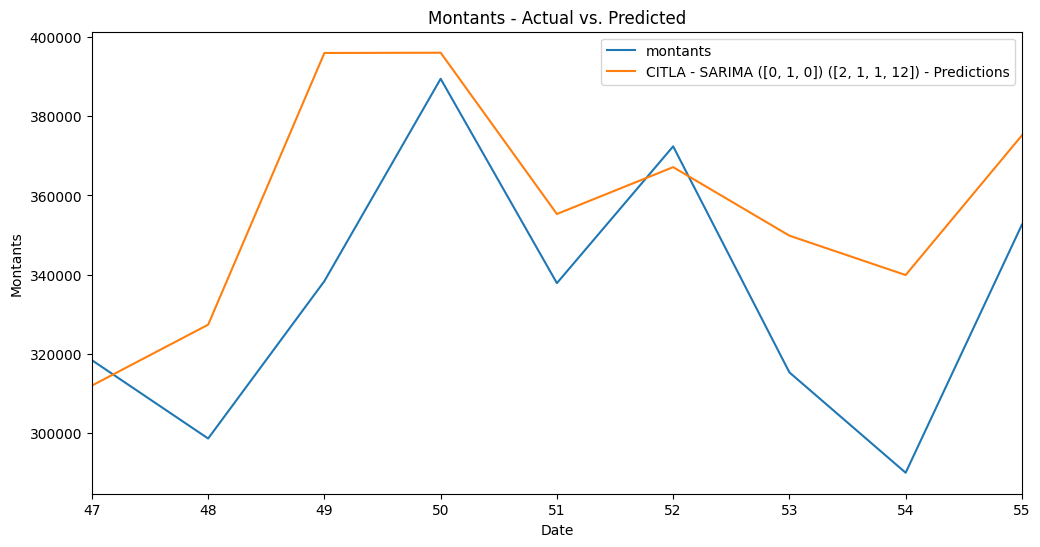

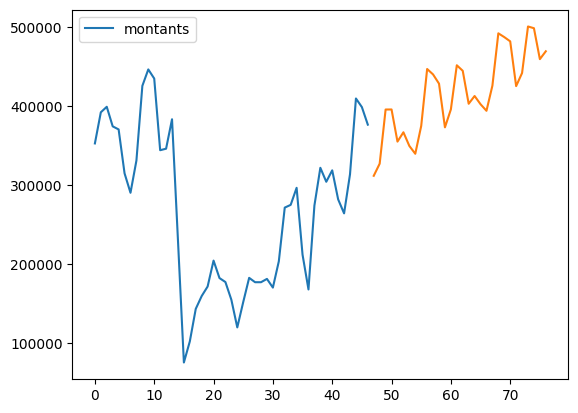

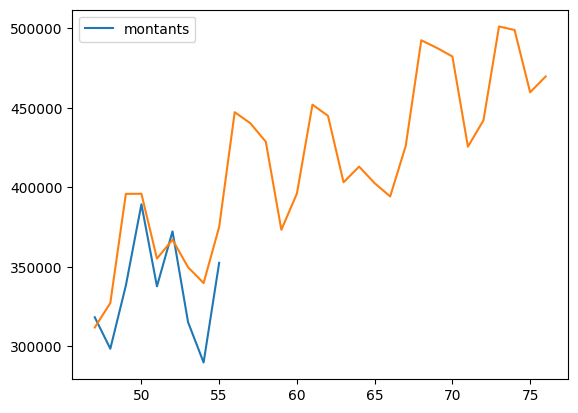

In [64]:
predT = []
forecast = []

for sect in secteur:
    print(sect)
    # Plot predictions against known values
    title = 'Montants - Actual vs. Predicted'
    ylabel='Montants'
    xlabel='Date'

    ax = data_testL[secteur==sect].plot(legend=True,figsize=(12,6),title=title)
    predictions[secteur==sect].plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)

    predT.append(data_testL[secteur==sect][['date','montants']])
    predT[secteur==sect]['pred'] = round(predictions[secteur==sect],2)
    predT[secteur==sect]['% err'] = round((abs(predT[secteur==sect]['montants'] - predT[secteur==sect]['pred'])/predT[secteur==sect]['montants'])*100,1)

    #mse = ((predictions[i] - data_testL[i].montants) ** 2).mean()
    #print('The Mean Squared Error is {}'.format(round(mse, 2)))
    #print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

    #data_testL[i]['pred'] = predictions[i]
    #predictions
    #data_testL[i].groupby(pd.to_datetime(data_testL[i]['date']).dt.year).apply(lambda x: statistics.mean(abs(x.montants - x.pred)))

    forecast.append(result[secteur==sect].forecast(steps=30))

    data_trainL[secteur==sect].plot()
    result[secteur==sect].forecast(steps=30).plot()

    data_testL[secteur==sect].plot()
    result[secteur==sect].forecast(steps=30).plot()

In [ ]:
# #Échantillon test-train
# dataL = [data.query(f"secteur==@secteur[{i}]").reset_index(drop=True) for i in range(0, len(secteur))]

# #Initialiser les listes pour contenir les infos
# data_trainL = [None] * len(secteur)
# data_testL = [None] * len(secteur)
# model = [None] * len(secteur)
# summary = [None] * len(secteur)

# for i in range(0, len(secteur)):
#     print(secteur[i])
#     #Échantillon train
#     data_trainL[i] = dataL[i][(dataL[i]['date'] < date_ech)]
#     #data_trainL[i] = pd.concat([data_train1L[i], data_train2L[i]])

#     #Échantillon test
#     data_testL[i] = dataL[i][(dataL[i]['date'] >= date_ech)]

#     model[i] = pm.auto_arima(data_trainL[i].montants,
#                     start_p=0, start_q=0,
#                     test='adf',       # use adftest to find optimal 'd'
#                     max_p=5, max_q=5, # maximum p and q
#                     m=12,              # frequency of series
#                     start_P=0, start_Q=0,
#                     max_P=5, max_Q=5,
#                     d=None,           # let model determine 'd'
#                     seasonal=True,     # Seasonality
#                     #d=1,
#                     D=1,
#                     trace=True,
#                     maxiter=70,
#                     information_criterion='aic',
#                     error_action='ignore',
#                     suppress_warnings=True,
#                     stepwise=True)
#     summary[i] = model[i].summary()


In [66]:
# final_model = [None] * len(secteur)
# result = [None] * len(secteur)
# predictions = [None] * len(secteur)
# predT = [None] * len(secteur)
# forecast = [None] * len(secteur)

# for i in range(0, len(secteur)):
#     print(secteur[i])
#     final_model[i]= SARIMAX(data_trainL[i].montants, order=(model_order[i]),seasonal_order=(seasonal_order[i])) 
#     result[i] = final_model[i].fit()
#     #print(result[i].summary())

#     #Graphique résidus
#     #result[i].plot_diagnostics(figsize=(15, 12))

#     #Obtenir les valeurs prédites
#     start=len(data_trainL[i])
#     end=len(data_trainL[i])+len(data_testL[i])-1

#     predictions[i] = result[i].predict(start=start, end=end, dynamic=False, typ='levels') \
#                     .rename(str(secteur[i])+' - SARIMA (' + str(model_order) + ') ('+ str(seasonal_order) + ') - Predictions')

In [ ]:
# # Plot predictions against known values
#     title = 'Montants - Actual vs. Predicted'
#     ylabel='Montants'
#     xlabel='Date'

#     ax = data_testL[i].plot(legend=True,figsize=(12,6),title=title)
#     predictions[i].plot(legend=True)
#     ax.autoscale(axis='x',tight=True)
#     ax.set(xlabel=xlabel, ylabel=ylabel)

#     predT[i] = data_testL[i][['date','montants']]
#     predT[i]['pred'] = round(predictions[i],2)
#     predT[i]['% err'] = round((abs(predT[i]['montants'] - predT[i]['pred'])/predT[i]['montants'])*100,1)

#     #mse = ((predictions[i] - data_testL[i].montants) ** 2).mean()
#     #print('The Mean Squared Error is {}'.format(round(mse, 2)))
#     #print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

#     #data_testL[i]['pred'] = predictions[i]
#     #predictions
#     #data_testL[i].groupby(pd.to_datetime(data_testL[i]['date']).dt.year).apply(lambda x: statistics.mean(abs(x.montants - x.pred)))

#     forecast[i] = result[i].forecast(steps=30)

#     data_trainL[i].plot()
#     result[i].forecast(steps=30).plot()

#     data_testL[i].plot()
#     result[i].forecast(steps=30).plot()